<a href="https://colab.research.google.com/github/sefeoglu/AE_Parseval_Network/blob/master/src/notebooks/ResNet_Tensorflow_keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Wide ResNet 16_2

In [0]:
import tensorflow as tf

# Model

In [2]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Add, Activation, Dropout, Flatten, Dense
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.regularizers import l2
from tensorflow.keras import backend as K
import warnings

warnings.filterwarnings("ignore")
weight_decay = 0.0001


def initial_conv(input):
  
    x = Convolution2D(16, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(input)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    return x


def expand_conv(init, base, k, strides=(1, 1)):
    x = Convolution2D(base * k, (3, 3), padding='same', strides=strides, kernel_initializer='he_normal', kernel_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = Convolution2D(base * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    skip = Convolution2D(base * k, (1, 1), padding='same', strides=strides, kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(init)

    m = Add()([x, skip])

    return m


def conv1_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(16 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv2_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    print("conv2:channel:  {}".format(channel_axis))
    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(32 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def conv3_block(input, k=1, dropout=0.0):
    init = input

    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    print("conv3 channel_axis:{} ".format(channel_axis))
    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(input)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    if dropout > 0.0: x = Dropout(dropout)(x)

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)
    x = Convolution2D(64 * k, (3, 3), padding='same', kernel_initializer='he_normal',
                      kernel_regularizer=l2(weight_decay),
                      use_bias=False)(x)

    m = Add()([init, x])
    return m

def create_wide_residual_network(input_dim, nb_classes=100, N=2, k=1, dropout=0.0, verbose=1):
    """
    Creates a Wide Residual Network with specified parameters

    :param input: Input Keras object
    :param nb_classes: Number of output classes
    :param N: Depth of the network. Compute N = (n - 4) / 6.
              Example : For a depth of 16, n = 16, N = (16 - 4) / 6 = 2
              Example2: For a depth of 28, n = 28, N = (28 - 4) / 6 = 4
              Example3: For a depth of 40, n = 40, N = (40 - 4) / 6 = 6
    :param k: Width of the network.
    :param dropout: Adds dropout if value is greater than 0.0
    :param verbose: Debug info to describe created WRN
    :return:
    """
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1

    ip = Input(shape=input_dim)

    x = initial_conv(ip)
    nb_conv = 4

    x = expand_conv(x, 16, k)
    nb_conv += 2

    for i in range(N - 1):
        x = conv1_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 32, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv2_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = expand_conv(x, 64, k, strides=(2, 2))
    nb_conv += 2

    for i in range(N - 1):
        x = conv3_block(x, k, dropout)
        nb_conv += 2

    x = BatchNormalization(axis=channel_axis, momentum=0.1, epsilon=1e-5, gamma_initializer='uniform')(x)
    x = Activation('relu')(x)

    x = AveragePooling2D((8, 8))(x)
    x = Flatten()(x)

    x = Dense(nb_classes, kernel_regularizer=l2(weight_decay), activation='softmax')(x)

    model = Model(ip, x)

    if verbose: print("Wide Residual Network-%d-%d created." % (nb_conv, k))
    return model

if __name__ == "__main__":

    init = (32, 32,1)

    wrn_16_2 = create_wide_residual_network(init, nb_classes=4, N=2, k=2, dropout=0.5)

    wrn_16_2.summary()



conv2:channel:  -1
conv3 channel_axis:-1 
Wide Residual Network-16-2 created.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 32, 1)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 32, 32, 16)   144         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 32, 32, 16)   64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 32, 32, 16)   0           batch_normalization[0][0]        
________________

# Data Prepare and Processing




In [0]:
from sklearn.model_selection import train_test_split
import gzip
import pickle

import numpy as np

In [0]:

with open('data_set.pickle', 'rb') as f:
    x = pickle.load(f)

In [0]:
X_train, y_train,X_test, y_test, X_val, y_val = x['X_train'], x['y_train'], x['X_test'], x['y_test'], x['X_val'], x['y_val']

In [0]:
def read_data():
    with open("data.pz", 'rb') as file_:
        with gzip.GzipFile(fileobj=file_) as gzf:
            data = pickle.load(gzf, encoding='latin1', fix_imports=True)
    return data
data = read_data()


In [0]:
import cv2
new_data_X = []
Y_data = []
for row in data:
    new_data_X.append(cv2.resize(row['crop'], (32,32)))
    Y_data.append(row['label'])
new_data_X = np.array(new_data_X)
new_data_X.shape

(5722, 32, 32)

In [0]:
X = new_data_X.astype('float32')
X.shape

(5722, 32, 32)

# Preprocessing

In [0]:
img_rows, img_cols = X[0].shape

# transform data set
if K.image_data_format() == 'channels_first':
    X = X.reshape(X.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    X = X.reshape(X.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [0]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

labelencoder = LabelEncoder()
y_df = pd.DataFrame(Y_data, columns=['Label'])
y_df['Encoded'] = labelencoder.fit_transform(y_df['Label'])

In [0]:
y_df['Label'].value_counts()

closed           1500
open             1500
partiallyOpen    1376
notVisible       1346
Name: Label, dtype: int64

In [0]:
y_df['Encoded'].value_counts()


2    1500
0    1500
3    1376
1    1346
Name: Encoded, dtype: int64

In [0]:
from tensorflow.keras.utils import to_categorical

y_cat = to_categorical(y_df['Encoded'])

# Training

In [0]:
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import Callback, LearningRateScheduler, EarlyStopping
import tensorflow

EPOCHS = 200
BS = 128
sgd = SGD(lr=0.1, momentum=0.6)

In [7]:
wrn_16_2.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])
print("Finished compiling")


Finished compiling


In [0]:
def lr_sch(epoch):
    if epoch < 30:
        return 0.1
    elif epoch < 50:
        return 0.001
    elif epoch < 60:
        return 0.001
    else:
        return 0.00001

# Learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_sch)

In [0]:
generator = tensorflow.keras.preprocessing.image.ImageDataGenerator(rotation_range=10,
                               width_shift_range=5./32,
                               height_shift_range=5./32,)

In [0]:
X_train, X_test, y_train, y_test = train_test_split(X, y_cat, test_size = 0.1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1)

In [11]:
hist = wrn_16_2.fit(generator.flow(X_train, y_train, batch_size=BS), steps_per_epoch=len(X_train) // BS, epochs=EPOCHS,
                   callbacks = [lr_scheduler],
                   validation_data=(X_val, y_val),
                   validation_steps=X_val.shape[0] // BS,)

Epoch 1/200
36/36 [==============================] - 2s 68ms/step - loss: 1.5912 - acc: 0.3079 - val_loss: 1.5338 - val_acc: 0.3845 - lr: 0.1000
Epoch 2/200
36/36 [==============================] - 2s 55ms/step - loss: 1.5084 - acc: 0.3673 - val_loss: 1.5161 - val_acc: 0.3883 - lr: 0.1000
Epoch 3/200
36/36 [==============================] - 2s 52ms/step - loss: 1.4671 - acc: 0.3806 - val_loss: 1.5058 - val_acc: 0.3592 - lr: 0.1000
Epoch 4/200
36/36 [==============================] - 2s 54ms/step - loss: 1.4622 - acc: 0.3877 - val_loss: 1.4645 - val_acc: 0.3689 - lr: 0.1000
Epoch 5/200
36/36 [==============================] - 2s 57ms/step - loss: 1.4451 - acc: 0.3886 - val_loss: 1.4417 - val_acc: 0.4078 - lr: 0.1000
Epoch 6/200
36/36 [==============================] - 2s 57ms/step - loss: 1.4361 - acc: 0.4099 - val_loss: 1.4039 - val_acc: 0.4039 - lr: 0.1000
Epoch 7/200
36/36 [==============================] - 2s 51ms/step - loss: 1.4344 - acc: 0.4099 - val_loss: 1.3981 - val_acc: 0.450

In [0]:
wrn_16_2.save("wrn_model.h5")

**Visualization**

dict_keys(['loss', 'acc', 'val_loss', 'val_acc', 'lr'])


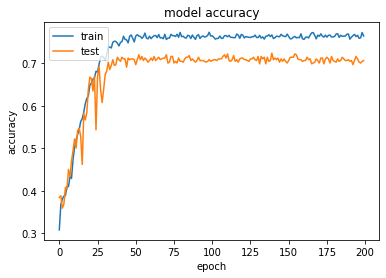

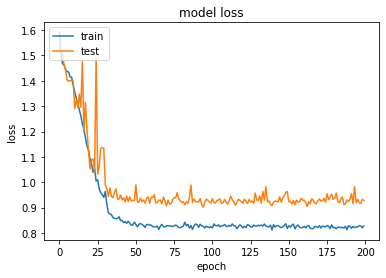

<Figure size 432x288 with 0 Axes>

In [13]:
import matplotlib.pyplot as plt

history = hist
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("wrn_tensor.png")
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("deneme.png")

In [14]:
wrn_16_2.evaluate(X_test,y_test)

18/18 [==============================] - 0s 8ms/step - loss: 0.8932 - acc: 0.7347


[0.8932190537452698, 0.7347294688224792]

In [0]:
wrn_16_2.evaluate(X_train,y_train)

145/145 [==============================] - 1s 4ms/step - loss: 1.1210 - acc: 0.8323


[1.1209561824798584, 0.8323262929916382]

# Adversarial Examples


In [15]:
!pip install -q tensorflow==2.0.0b1
# Install bleeding edge version of cleverhans
!pip install git+https://github.com/tensorflow/cleverhans.git#egg=cleverhans

import cleverhans
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

print("\nTensorflow Version: " + tf.__version__)
print("Cleverhans Version: " + cleverhans.__version__)
print("GPU Available: ", tf.test.is_gpu_available())

     |████████████████████████████████| 87.9MB 52kB/s 
     |████████████████████████████████| 501kB 43.5MB/s 
     |████████████████████████████████| 3.1MB 37.1MB/s 
  Cloning https://github.com/tensorflow/cleverhans.git to /tmp/pip-install-ahbkk35p/cleverhans
  Running command git clone -q https://github.com/tensorflow/cleverhans.git /tmp/pip-install-ahbkk35p/cleverhans
     |████████████████████████████████| 163kB 2.6MB/s 
     |████████████████████████████████| 51kB 4.1MB/s 
  Created wheel for cleverhans: filename=cleverhans-3.0.1-cp36-none-any.whl size=262572 sha256=371ac51e4c3e7e37696d6ede8cdd58b5d9cba16844d9fa736bc6fb3236da419c
  Stored in directory: /tmp/pip-ephem-wheel-cache-xr27wh9n/wheels/6e/59/ec/723a6f654aaf62c8c40f0f0850fdf71a4948598697f56c3bfa
Successfully built cleverhans

Tensorflow Version: 2.2.0
Cleverhans Version: 3.0.1-fc7b7c7ec903258e0e3fb88503fa629f
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
GPU Available:  True


In [0]:
from cleverhans.future.tf2.attacks import fast_gradient_method

#The attack requires the model to ouput the logits
logits_model = tf.keras.Model(wrn_16_2.input,wrn_16_2.layers[-1].output)

In [0]:
X_adv = []
epsilon_list = [0.005]
for j in range(len(epsilon_list)):
  epsilon = epsilon_list[j]
  for i in range(len(X_test)):
    random_index = i
    original_image = X_test[random_index]
    original_image = tf.convert_to_tensor(original_image.reshape((1,32,32))) #The .reshape just gives it the proper form to input into the model, a batch of 1 a.k.a a tensor
    original_label = y_test[random_index]
    original_label = np.reshape(np.argmax(original_label), (1,)).astype('int64')
    adv_example_targeted_label = fast_gradient_method(logits_model, original_image, epsilon, np.inf, targeted=False)
    X_adv.append(np.array(adv_example_targeted_label).reshape(32,32,1))

In [18]:
  X_adv = np.array(X_adv)
  print("epsilon: {} and test evalution : {}".format(epsilon,wrn_16_2.evaluate(X_adv,y_test)))

18/18 [==============================] - 0s 5ms/step - loss: 2.8275 - acc: 0.2286
epsilon: 0.1 and test evalution : [2.8275392055511475, 0.22862128913402557]


In [20]:
  X_adv = np.array(X_adv)
  print("epsilon: {} and test evalution : {}".format(epsilon,wrn_16_2.evaluate(X_adv,y_test)))

18/18 [==============================] - 0s 5ms/step - loss: 0.9418 - acc: 0.6876
epsilon: 0.01 and test evalution : [0.9417540431022644, 0.687609076499939]


In [22]:
  X_adv = np.array(X_adv)
  print("epsilon: {} and test evalution : {}".format(epsilon,wrn_16_2.evaluate(X_adv,y_test)))

18/18 [==============================] - 0s 5ms/step - loss: 0.8955 - acc: 0.7120
epsilon: 0.005 and test evalution : [0.8954875469207764, 0.7120419144630432]


In [0]:
  X_adv = np.array(X_adv)
  print("epsilon: {} and test evalution : {}".format(epsilon,wrn_16_2.evaluate(X_adv,y_test)))

18/18 [==============================] - 0s 12ms/step - loss: 1.0721 - acc: 0.6178
epsilon: 0.015 and test evalution : [1.0720562934875488, 0.6178010702133179]


# Adversarial Training

In [0]:
y_adv = np.array(y_adv)

In [0]:
y_adv_df = pd.DataFrame(y_adv, columns=['Encoded'])
y_adv_df['Encoded'] = labelencoder.fit_transform(y_adv)

In [0]:
y_adv_df['Encoded'].value_counts()

In [0]:
X_new = []
X_adv =my_data['image']
for i in range(len(X_adv)):
  a = np.array(X_adv[i])
  X_new.append(a.reshape(68,100,1))

In [0]:
for i in range(len(X)):
  a = np.array(X[i])
  X_new.append(a)

In [0]:
X_third = np.array(X_new)

In [0]:
X_adv_a = np.array(X_new)

In [0]:
X_adv_a.shape

In [0]:
y_new = []
for j in range(0,2):
  for i in range(len(y_cat)):
    y_new.append(y_cat[i])
y_third = np.array(y_new)

In [0]:
X_all, y_all = X_third, y_third

In [0]:
X_train_adv, X_test_adv, y_train_adv, y_test_adv = train_test_split( X_all,y_all, test_size = 0.33, shuffle=True)

In [0]:
wrn_16_2_adv = create_wide_residual_network(init, nb_classes=4, N=2, k=2, dropout=0.3)

In [0]:
wrn_16_2_adv.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])
print("Finished compiling")
BS_adv= 100
EPOCHS_adv = 50

In [0]:
def lr_sch_train(epoch):
    if epoch < 10:
        return 0.1
    elif epoch <20:
        return 0.1/2.0
    elif epoch < 30:
        return 0.1/2.0**2
    elif epoch < 40:
        return 0.1/2.0**3
    else:
        return 0.1/2.0**4

# Learning rate scheduler callback
lr_scheduler_train = LearningRateScheduler(lr_sch_train)

In [0]:

hist = wrn_16_2_adv.fit_generator(generator.flow(X_train_adv, y_train_adv, batch_size=BS_adv), steps_per_epoch=len(X_train_adv) // BS_adv, epochs=EPOCHS_adv,
                   callbacks=[lr_scheduler_train],
                   validation_data=(X_test_adv, y_test_adv),
                   validation_steps=X_test_adv.shape[0] // BS_adv,)

In [0]:
wrn_16_2_adv.save("model_adv_wrn_tensor_dropout.h5")

**Visualization**

In [0]:
import matplotlib.pyplot as plt

history = hist
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("wrn_tensor.png")
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("deneme.png")

**CleanExperiment**

In [0]:
wrn_16_2_clean = create_wide_residual_network(init, nb_classes=4, N=2, k=2, dropout=0.3)

In [0]:
wrn_16_2_clean.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["acc"])
print("Finished compiling")

In [0]:
hist_clean = wrn_16_2_clean.fit_generator(generator.flow(X_train, y_train, batch_size=BS_adv), steps_per_epoch=len(X_train) // BS_adv, epochs=EPOCHS_adv,
                   callbacks=[lr_scheduler_train],
                   validation_data=(X_test, y_test),
                   validation_steps=X_test.shape[0] // BS_adv,)

In [0]:
wrn_16_2_clean.save("model_adv_train_clean_dropout.h5")

**Visualization**

In [0]:
import matplotlib.pyplot as plt

history = hist_clean
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("wrn_tensor.png")
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig("deneme.png")

**Adversarial Training**

In [0]:
wrn_16_2_adv.evaluate(X_train,y_train)

In [0]:
wrn_16_2_adv.evaluate(X_train_adv,y_train_adv)

In [0]:
wrn_16_2_adv.evaluate(X_test,y_test)

In [0]:
wrn_16_2_adv.evaluate(X_adv_a,y_cat)

In [0]:
wrn_16_2_adv.evaluate(X_test_adv,y_test_adv)

**Non_Adversarial_Training**

In [0]:
wrn_16_2_clean.evaluate(X_train, y_train)

In [0]:
wrn_16_2_clean.evaluate(X_train_adv,y_train_adv)

In [0]:
wrn_16_2_clean.evaluate(X_test, y_test)

In [0]:
wrn_16_2_clean.evaluate(X_adv_a,y_cat)

In [0]:
wrn_16_2_clean.evaluate(X_test_adv, y_test_adv)